In [1]:
from transformers import GPT2Tokenizer
from torch.nn import CrossEntropyLoss
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from datasets import load_dataset


data_path = "/home/sohampoddar/HDD2/utsav/Dataset/IMDB Dataset.csv"
# Load IMDB dataset (3000 train, 1000 test)
dataset = load_dataset('csv', data_files= data_path)
train_subset = dataset["train"].shuffle(seed=42).select(range(7000))
test_subset = dataset["train"].shuffle(seed=42).select(range(2000))
dataset = {"train": train_subset, "test": test_subset}

In [2]:
from torch.utils.data import DataLoader, Dataset
label_map = {"negative": 0, "positive": 1}
class IMDBDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length=512):
        self.tokenizer = tokenizer
        self.texts = dataset["review"]
        self.labels = [label_map[label] for label in dataset["sentiment"]]
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encodings = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        input_ids = encodings["input_ids"].squeeze()
        attention_mask = encodings["attention_mask"].squeeze()
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return input_ids, attention_mask, label, idx
    
class SentimentClassifier(nn.Module):
    def __init__(self, transformer, hidden_dim=768, num_classes=2):
        super(SentimentClassifier, self).__init__()
        self.transformer = transformer
        self.classifier = nn.Linear(50257, num_classes)  # Maps hidden state → sentiment classes

    def forward(self, input_ids, attention_mask):
        outputs = self.transformer(input_ids)  # (batch, seq_len, hidden_dim)
        pooled_output = outputs.mean(dim=1)  # Mean pool across sequence length
        logits = self.classifier(pooled_output)  # Shape: (batch_size, 2)
        return logits

    

In [3]:
import torch
from transformer_lens import HookedTransformer
# load the base model and tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# Load HookedTransformer GPT-2 model
base_model = HookedTransformer.from_pretrained("gpt2-small", device=device)

# Create the sentiment classifier model
base_classifier = SentimentClassifier(base_model).to(device)

Loaded pretrained model gpt2-small into HookedTransformer


In [4]:
test_dataset = IMDBDataset(dataset["test"], tokenizer)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

In [5]:
for input_ids, attention_mask, labels, idx in test_loader:
    print(labels)
    break

tensor([0, 1, 0, 0])


In [5]:
base_classifier.eval()
correct = 0
total = 0
# store the data points  where it predicts wrong
# make an empty dataset to store the wrong predictions
correct_confidence = []
wrong_confidence = []
correct_predictions = []
wrong_predictions = []
with torch.no_grad():
    for input_ids, attention_mask, labels, idx in test_loader:
        input_ids, attention_mask, labels, idx = input_ids.to(device), attention_mask.to(device), labels.to(device), idx.to(device)
        logits = base_classifier(input_ids, attention_mask)
        confidence = torch.nn.functional.softmax(logits, dim=1)
        confidence = confidence.max(dim=1).values
        _, predicted = torch.max(logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        correct_predictions.extend(idx[predicted == labels
        ].tolist())
        wrong_predictions.extend(idx[predicted != labels].tolist())
        correct_confidence.extend(confidence[predicted == labels].tolist())
        wrong_confidence.extend(confidence[predicted != labels].tolist())

print(f"Accuracy: {correct / total:.2f}")
print(f"Number of wrong predictions: {total - correct}")
print("Correct predictions: ", correct)
correct_confidence = sum(correct_confidence) / len(correct_confidence)
wrong_confidence = sum(wrong_confidence) / len(wrong_confidence)    
print("Average confidence of correct predictions: ", correct_confidence)
print("Average confidence of wrong predictions: ", wrong_confidence)

Accuracy: 0.50
Number of wrong predictions: 1009
Correct predictions:  991
Average confidence of correct predictions:  0.6691729257975289
Average confidence of wrong predictions:  0.6746055887286562


In [6]:
# convert the wrong predictions to a dataset
wrong_dataset = [test_dataset[i] for i in wrong_predictions]
wrong_loader = DataLoader(wrong_dataset, batch_size=4, shuffle=True)
correct_dataset = [test_dataset[i] for i in correct_predictions]
correct_loader = DataLoader(correct_dataset, batch_size=4, shuffle=True)

In [7]:
loaded_model = SentimentClassifier(base_model).to(device)
loaded_model.load_state_dict(torch.load("/home/sohampoddar/HDD2/utsav/MI/gpt2-imdb-finetuned.pt"))

<All keys matched successfully>

In [8]:
loaded_model.eval()
correct = 0
total = 0
# also calculate average confidence scores for correct and wrong predictions
correct_confidence = []
wrong_confidence = []
with torch.no_grad():
    for input_ids, attention_mask, labels, idx in test_loader:
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        logits = loaded_model(input_ids, attention_mask)
        # calculate confidence scores
        confidence = torch.nn.functional.softmax(logits, dim=1)
        confidence = confidence.max(dim=1).values
        _, predicted = torch.max(logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        correct_confidence.extend(confidence[predicted == labels].tolist())
        wrong_confidence.extend(confidence[predicted != labels].tolist())

print(f"Accuracy: {correct / total:.2f}")
print("Correct: ", correct)
print("Total: ", total)
# average confidence scores
correct_confidence = sum(correct_confidence) / len(correct_confidence)
wrong_confidence = sum(wrong_confidence) / len(wrong_confidence)
print(f"Average confidence for correct predictions: {correct_confidence:.2f}")
print(f"Average confidence for wrong predictions: {wrong_confidence:.2f}")

Accuracy: 0.96
Correct:  1918
Total:  2000
Average confidence for correct predictions: 0.94
Average confidence for wrong predictions: 0.72


In [9]:
# do evaluation on the correct dataset
correct = 0
total = 0
with torch.no_grad():
    for input_ids, attention_mask, labels, idx in correct_loader:
        input_ids, attention_mask, labels, idx = input_ids.to(device), attention_mask.to(device), labels.to(device), idx.to(device)
        logits = loaded_model(input_ids, attention_mask)
        _, predicted = torch.max(logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {correct / total:.2f}")
print("Correct: ", correct)
print("Wrong", total - correct)
print("Total: ", total)

Accuracy: 0.96
Correct:  949
Wrong 42
Total:  991


In [10]:
# do evaluation on the wrong dataset
correct = 0
total = 0
with torch.no_grad():
    for input_ids, attention_mask, labels, idx in wrong_loader:
        input_ids, attention_mask, labels, idx = input_ids.to(device), attention_mask.to(device), labels.to(device), idx.to(device)
        logits = loaded_model(input_ids, attention_mask)
        _, predicted = torch.max(logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {correct / total:.2f}")
print("Correct: ", correct)
print("Wrong", total - correct)
print("Total: ", total)

Accuracy: 0.96
Correct:  969
Wrong 40
Total:  1009


In [25]:
import torch as t
import einops

def get_top_k_attention(model,text,p=10):

    # tokenize the input text
    tokens = model.transformer.to_tokens(text)

    model_logits , model_cache = model.transformer.run_with_cache(tokens,remove_batch_dim = True)

    # we would analyse layer 1
    layer = 11
    attn_scores = model_cache["pattern", layer]  # Shape: (nhead, seq, seq)

    # Average over all attention heads to get a single matrix
    avg_attn_scores = attn_scores.mean(dim=0)  # Shape: (seq, seq)
    # Get top K attention scores for each token
    topk_values, topk_indices = t.topk(avg_attn_scores, p, dim=-1)

    return topk_indices, topk_values, tokens

In [26]:
gpt2_text = "Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."
k = 10
base_topk_indices, base_topk_values, base_tokens = get_top_k_attention(base_classifier, gpt2_text, p=k)
fine_topk_indices, fine_topk_values, fine_tokens = get_top_k_attention(loaded_model, gpt2_text,p=k)

# base_topk_indices, fine_topk_indices

In [ ]:
base_topk_indices, fine_topk_indices

In [28]:
get_jaccard_scores(base_topk_indices, fine_topk_indices,base_tokens, fine_tokens, gpt2_text)

Last word: them. | Jaccard score: 1.00
Average Jaccard score: 1.00


In [29]:
def get_jaccard_scores(base_topk_indices, fine_topk_indices,base_tokens,fine_tokens,text):
        seq_len = base_topk_indices.shape[0]
        jaccard_scores = []

        for i in range(seq_len):
            base_topk_set = set(base_topk_indices[i].tolist())
            fine_topk_set = set(fine_topk_indices[i].tolist())

            intersection = len(base_topk_set & fine_topk_set)  # Common elements
            union = len(base_topk_set | fine_topk_set)  # Total unique elements

            jaccard_coeff = intersection / union if union > 0 else 0  # Avoid division by zero
            jaccard_scores.append(jaccard_coeff)

        # Compute average Jaccard coefficient for the text
        average_jaccard = sum(jaccard_scores) / len(jaccard_scores)
        
        # print the ;ast word of the text and the last jaccard scores 
        print(f"Last word: {text.split()[-1]} | Jaccard score: {jaccard_scores[-1]:.2f}")
        print(f"Average Jaccard score: {average_jaccard:.2f}")

In [30]:
# loop through the texts in the test dataset and get the top k attention scores
top_k = 10
for input_ids, attention_mask, labels, idx in wrong_loader:
    input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
    for i in range(input_ids.size(0)):
        text = tokenizer.decode(input_ids[i])
        fine_topk_indices, fine_topk_values, loaded_tokens = get_top_k_attention(loaded_model,text,p=top_k)
        base_topk_indices, base_topk_values, base_tokens = get_top_k_attention(base_classifier,text,p=top_k)
        
        get_jaccard_scores(base_topk_indices, fine_topk_indices, base_tokens, loaded_tokens,text)
        

Last word: je | Jaccard score: 1.00
Average Jaccard score: 1.00
Last word: (2/10)<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endofte

KeyboardInterrupt: 

In [31]:
# check logits of the base model and the fine tuned model
with torch.no_grad():
    for input_ids, attention_mask, labels, idx in wrong_loader:
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        logits = loaded_model(input_ids, attention_mask)
        base_logits = base_classifier(input_ids, attention_mask)
        print(logits)
        print(base_logits)
        break

tensor([[ 2.0503, -1.1502],
        [ 2.6120, -1.6909],
        [ 3.7700, -2.9638],
        [-0.6813,  1.5512]], device='cuda:0')
tensor([[ 0.0429,  0.5400],
        [-0.1172,  0.6407],
        [ 0.0488,  0.4124],
        [ 0.2201,  0.9859]], device='cuda:0')


In [32]:
gpt2_text = "Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."
tokens = base_classifier.transformer.to_tokens(text)

with torch.no_grad():
   base_model_logits , base_model_cache = base_classifier.transformer.run_with_cache(tokens,remove_batch_dim = True)
   fine_model_logits , fine_model_cache = loaded_model.transformer.run_with_cache(tokens,remove_batch_dim = True)

In [34]:
import numpy as np

# Define layers to inspect
layers_to_check = [0,1,2,3,4,5,6,7,8,9,10,11]  # Change these based on actual impact

for layer in layers_to_check:
    base_activations = base_model_cache[f'blocks.{layer}.mlp.hook_post'].cpu().numpy()
    fine_activations = fine_model_cache[f'blocks.{layer}.mlp.hook_post'].cpu().numpy()
    
    # Compute mean absolute difference
    diff = np.abs(base_activations - fine_activations).mean()
    
    print(f"Layer {layer} - Mean Activation Difference: {diff:.6f}")


Layer 0 - Mean Activation Difference: 0.000000
Layer 1 - Mean Activation Difference: 0.000000
Layer 2 - Mean Activation Difference: 0.000000
Layer 3 - Mean Activation Difference: 0.000000
Layer 4 - Mean Activation Difference: 0.000000
Layer 5 - Mean Activation Difference: 0.000000
Layer 6 - Mean Activation Difference: 0.000000
Layer 7 - Mean Activation Difference: 0.000000
Layer 8 - Mean Activation Difference: 0.000000
Layer 9 - Mean Activation Difference: 0.000000
Layer 10 - Mean Activation Difference: 0.000000
Layer 11 - Mean Activation Difference: 0.000000


In [35]:
base_hidden= base_model_cache["resid_post", -1]  # Last residual stream
fine_hidden= fine_model_cache["resid_post", -1]   

activation_diff = torch.abs(base_hidden - fine_hidden).mean().item()

print(f"Mean Activation Difference in lm_head Input: {activation_diff:.6f}")

Mean Activation Difference in lm_head Input: 0.000000


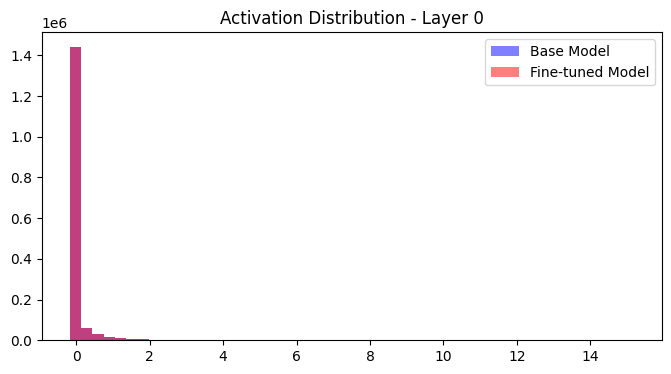

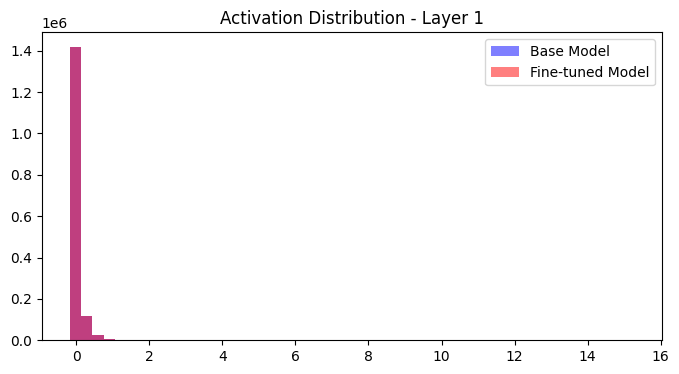

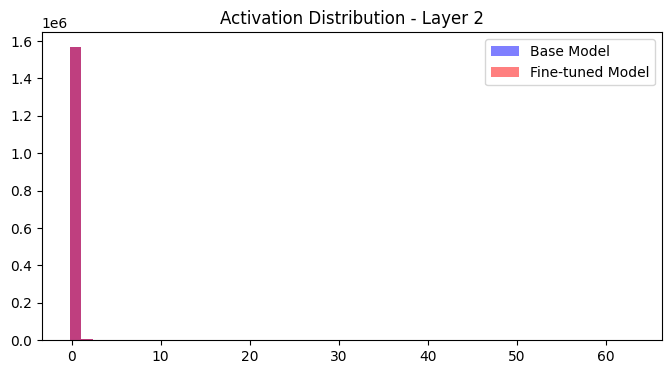

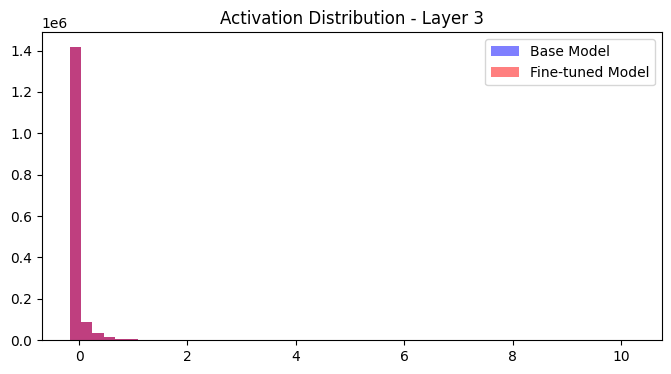

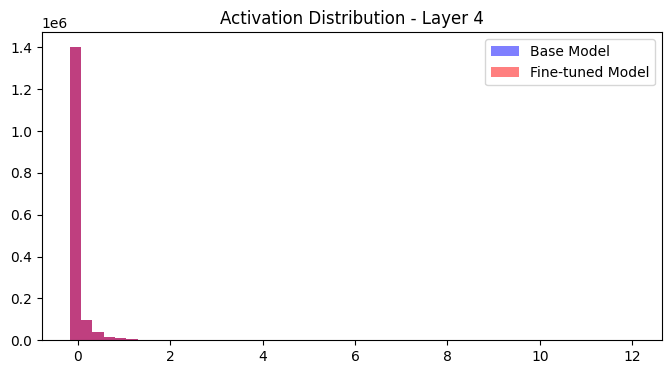

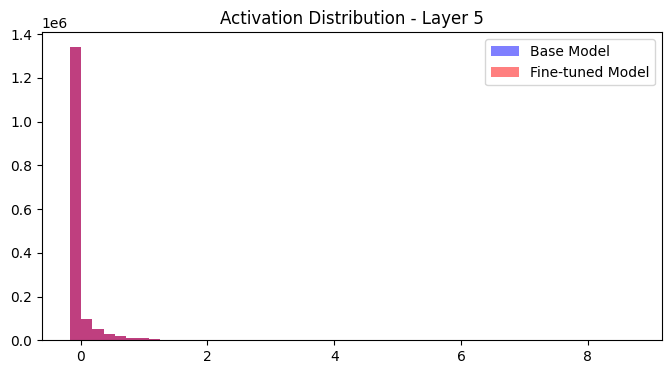

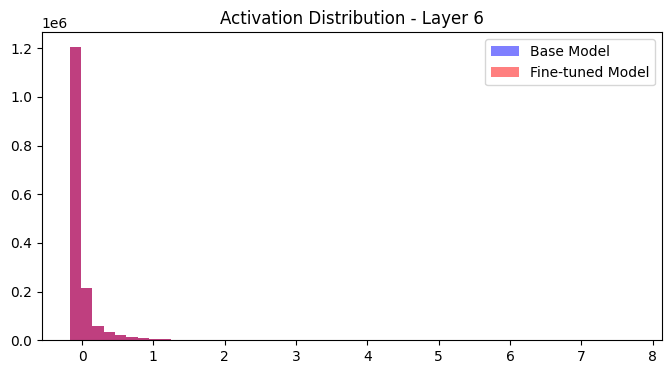

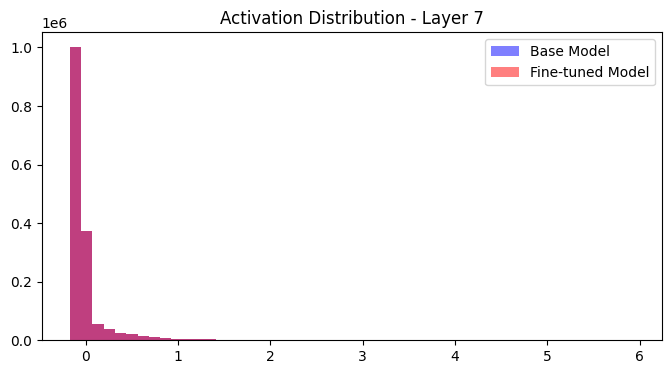

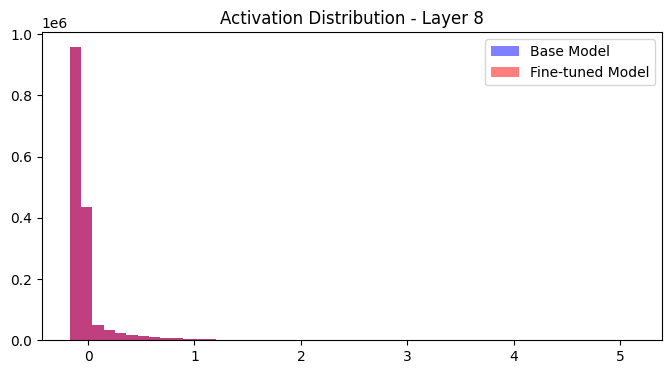

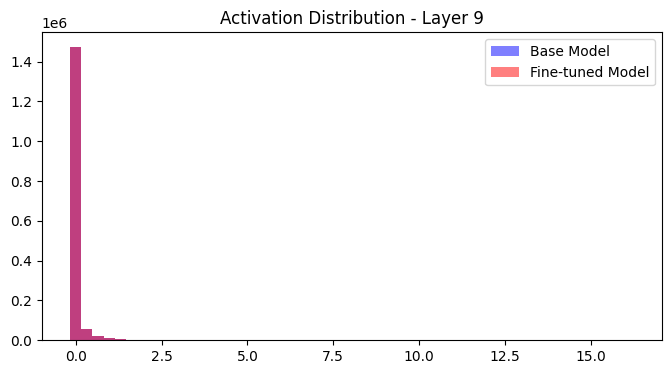

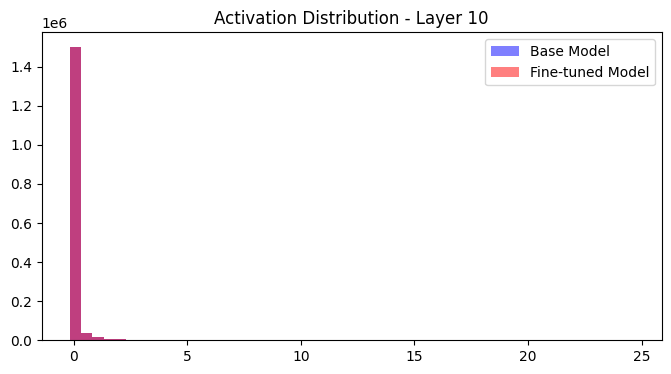

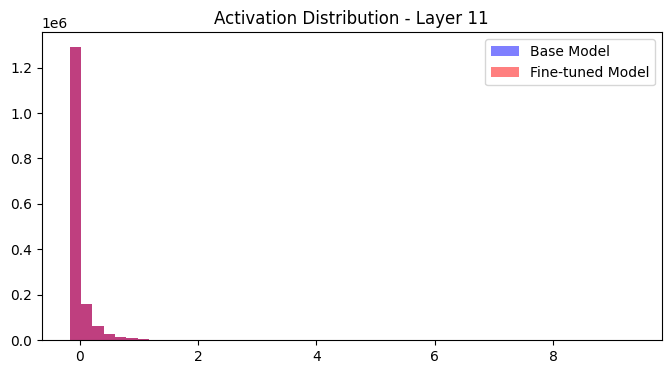

In [36]:
import matplotlib.pyplot as plt

for layer in layers_to_check:
    base_activations = base_model_cache[f'blocks.{layer}.mlp.hook_post'].cpu().numpy()
    fine_activations = fine_model_cache[f'blocks.{layer}.mlp.hook_post'].cpu().numpy()
    
    plt.figure(figsize=(8, 4))
    plt.hist(base_activations.flatten(), bins=50, alpha=0.5, label="Base Model", color="blue")
    plt.hist(fine_activations.flatten(), bins=50, alpha=0.5, label="Fine-tuned Model", color="red")
    plt.title(f"Activation Distribution - Layer {layer}")
    plt.legend()
    plt.show()

In [36]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

In [37]:
def predict_sentiment(text, model, tokenizer):
    model.eval()  # Ensure model is in eval mode

    # Tokenize input text
    encoding = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    # Get logits from the model
    with torch.no_grad():
        logits = model(input_ids, attention_mask) # we can print logits etc here

    # Convert logits to probabilities
    probs = torch.softmax(logits, dim=-1)
    pred_label = torch.argmax(probs, dim=-1).item()

    # Map label to sentiment
    sentiment_map = {0: "Negative", 1: "Positive"}
    return sentiment_map[pred_label], probs.cpu().numpy()

In [38]:
sample_text = "This show was an amazing, fresh & innovative idea in the 70's when it first aired. The first 7 or 8 years were brilliant, but things dropped off after that. By 1990, the show was not really funny anymore, and it's continued its decline further to the complete waste of time it is today.<br /><br />It's truly disgraceful how far this show has fallen. The writing is painfully bad, the performances are almost as bad - if not for the mildly entertaining respite of the guest-hosts, this show probably wouldn't still be on the air. I find it so hard to believe that the same creator that hand-selected the original cast also chose the band of hacks that followed. How can one recognize such brilliance and then see fit to replace it with such mediocrity? I felt I must give 2 stars out of respect for the original cast that made this show such a huge success. As it is now, the show is just awful. I can't believe it's still on the air."
sentiment, probabilities = predict_sentiment(sample_text,loaded_model, tokenizer)
print(f"Predicted Sentiment: {sentiment}")
print(f"Class Probabilities: {probabilities}")

Predicted Sentiment: Negative
Class Probabilities: [[0.9138813  0.08611865]]


In [39]:
sample_text = "This show was an amazing, fresh & innovative idea in the 70's when it first aired. The first 7 or 8 years were brilliant, but things dropped off after that. By 1990, the show was not really funny anymore, and it's continued its decline further to the complete waste of time it is today.<br /><br />It's truly disgraceful how far this show has fallen. The writing is painfully bad, the performances are almost as bad - if not for the mildly entertaining respite of the guest-hosts, this show probably wouldn't still be on the air. I find it so hard to believe that the same creator that hand-selected the original cast also chose the band of hacks that followed. How can one recognize such brilliance and then see fit to replace it with such mediocrity? I felt I must give 2 stars out of respect for the original cast that made this show such a huge success. As it is now, the show is just awful. I can't believe it's still on the air."
sentiment, probabilities = predict_sentiment(sample_text,base_classifier, tokenizer)
print(f"Predicted Sentiment: {sentiment}")
print(f"Class Probabilities: {probabilities}")

Predicted Sentiment: Positive
Class Probabilities: [[0.48732337 0.51267666]]
